## This notebook produces quality assurance (QA) plots for data that has been preprocessed for ML studies
#### Notebook assumes that the data is stored in compressed pickle files.
#### There should be the following files: means.p (means of data), stdvs.p (standard deviations of data), and data_XYZ.p where XYZ is a number. 
#### data_XYZ.p is the preprocessed data we'll be looking at
#### Notebook also assumes the pickle files contain variables/scalar keys "momentum"/"genP", "theta", "phi", "clusterE"/"cluster_energy"
#### Inside the targets list in data_XYZ.p, each entry should be a tuple with an order of (momentum, theta, phi), (momentum, theta), or (momentum)

In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import compress_pickle
import os
import mplhep as hep
hep.style.use(hep.style.CMS)

In [2]:
# Directory where your preprocessed data is stored
preprocessed_data_directory = "/home/ryan/zdc_studies/preprocessed_data/preprocessed_input4D_output2D_zdc_h4_neutron_graphnet_energy0.5_theta0.5_correctdynamicrange"

### Defining functions to extract the data from the compressed pickle files

In [3]:
# Opens a compressed pickle file, crashes if file doesn't exist
def open_compressed_pickle_file(file_name, compression="gzip"):
    with open(file_name, 'rb') as file:
        try:
            return compress_pickle.load(file, compression)
        except FileNotFoundError:
            raise FileNotFoundError(f"File does not exist: {file_name}")

# Returns dictionaries containing arrays of:
# Unnormalized + normalized targets
# Unnormalized + normalized nodes
# The file_number in the arguments is the number in "data_XYZ.p" file name
# The data type in the arguments is either "train", "val", or "test"
def obtain_data_from_pickle_file(preprocessed_data_directory, file_number='000', data_type='train'):
    # Opening the pickle files -- data_XYZ.p, means.p, stdvs.p
    preprocessed_file_name = f"{preprocessed_data_directory}/{data_type}/data_{file_number}.p"
    print(f"Using file {preprocessed_file_name}")
    preprocessed_data = open_compressed_pickle_file(preprocessed_file_name)
    mean_data = open_compressed_pickle_file(preprocessed_data_directory + "/means.p")
    standard_deviation_data = open_compressed_pickle_file(preprocessed_data_directory + "/stdvs.p")
    print("Means: ", mean_data)
    print("Standard deviations: ", standard_deviation_data)
    # Getting the targets used in this preprocessed data. Targets are what the ML model is trying to predict for each event
    scalar_keys = list(mean_data.keys())
    target_variables = [key for key in ["momentum", "genP", "theta", "phi"] if key in scalar_keys]
    if not target_variables:
        raise ValueError("No target variables found in scalar keys!")
    print(f"The target variables (excluding potential classification) are {', '.join(target_variables)}")
    
    # Will now grab the graphs and target data from the data_XYZ.p file
    # preprocessed_data is a list containing a 3-tuple for each event in the file
    # Tuple is (graph, targets, meta info)
    
    # Obtaining the targets for all the events
    event_targets = [event_data[1] for event_data in preprocessed_data]
    # Separating the targets into different arrays and storing these in a dictionary
    # The targets tuple should be arranged (momentum, theta, phi, particle_type)
    # Momentum will always be included
    # If phi is a target, theta will be too
    # If particle_type is a target (i.e. if classification is turned on), the particle type will be the last entry
    # We will ignore particle type for these QA plots
    # Reminder: The saved targets are z-score normalized by the means and standard deviations
    normalized_target_arrays = {var: np.array([event_target[index] for event_target in event_targets])
                                for index, var in enumerate(target_variables)}

    # Unnormalizing the target data to get the actual target values and storing it in a dictionary
    # Reminder: The saved momentum is log10(normalized momentum)
    unnormalized_target_arrays = {}
    for var in target_variables:
        unnormalized_target = normalized_target_arrays[var] * standard_deviation_data[var] + mean_data[var]
        if var in ["genP", "momentum"]:
            unnormalized_target = 10**unnormalized_target
        unnormalized_target_arrays[var] = unnormalized_target
    
    # Obtaining the graphs for all the events
    event_graphs = [event_data[0] for event_data in preprocessed_data]
    # Lists to contain the data from the graph for each event
    normalized_cluster_energy = []
    # The below lists will have multiple nested lists
    # Each nested list contains the information for all nodes in that event
    # e.g. energy will contain a list for each event, each containing the energy of the nodes in that event
    energy = []
    z = []
    x = []
    y = []
    # Loop through event graphs and extract node data
    for graph in event_graphs:
        # Extract the cluster energy from globals and add to list
        normalized_cluster_energy.append(graph["globals"][0])

        # Convert the nodes to a numpy array and transpose to separate attributes
        event_nodes = np.array(graph["nodes"]).T
        energy.append(event_nodes[0])
        z.append(event_nodes[1])
        x.append(event_nodes[2])
        y.append(event_nodes[3])
    normalized_cluster_energy = np.array(normalized_cluster_energy)
    normalized_node_arrays = {
        "energy": energy,
        "z": z,
        "x": x,
        "y": y,
        "cluster_energy": normalized_cluster_energy
    }
    
    try:
        detector_energy_key = next(key for key in scalar_keys if ".energy" in key)
    except StopIteration:
        raise ValueError("Detector energy key not found in scalar keys!")
    
    unnormalized_node_arrays = {}
    unnormalized_node_arrays["energy"] = [10**(event_node*standard_deviation_data[detector_energy_key] + mean_data[detector_energy_key]) for event_node in energy]
    unnormalized_node_arrays["z"] = [event_node*standard_deviation_data['.position.z'] + mean_data['.position.z'] for event_node in z]
    unnormalized_node_arrays["x"] = [event_node*standard_deviation_data['.position.x'] + mean_data['.position.x'] for event_node in x]
    unnormalized_node_arrays["y"] = [event_node*standard_deviation_data['.position.y'] + mean_data['.position.y'] for event_node in y]
    
    # Unnormalizing the cluster energy
    # Reminder: cluster energy is the sum of all the detector cell energies, divided by the sampling fraction
    # Saved cluster energy is log10(normalized cluster energy)
    cluster_energy_key = "clusterE" if "clusterE" in scalar_keys else "cluster_energy"
    unnormalized_cluster_energy = 10**(normalized_cluster_energy*standard_deviation_data[cluster_energy_key] + mean_data[cluster_energy_key])
    unnormalized_node_arrays["cluster_energy"] = unnormalized_cluster_energy
    
    return unnormalized_target_arrays, normalized_target_arrays, unnormalized_node_arrays, normalized_node_arrays

In [4]:
unnormalized_targets, normalized_targets, unnormalized_nodes, normalized_nodes = obtain_data_from_pickle_file(preprocessed_data_directory, '000', 'train')

Using file /home/ryan/zdc_studies/preprocessed_data/preprocessed_input4D_output2D_zdc_h4_neutron_graphnet_energy0.5_theta0.5_correctdynamicrange/train/data_000.p
Means:  {'ZDCHcalHitsReco.energy': -2.9885517692774144, '.position.z': 34771.46332749288, '.position.x': 0.2753695236163206, '.position.y': 0.3505375899780747, 'clusterE': 1.6657312945267295, 'genP': 1.741268408203125, 'theta': 2.603085302734375}
Standard deviations:  {'ZDCHcalHitsReco.energy': 0.5242519519924232, '.position.z': 1724.2732334939615, '.position.x': 123.52777785267233, '.position.y': 123.48914625013197, 'clusterE': 0.4593812412035674, 'genP': 0.42628727659773313, 'theta': 1.5254436518121897}
The target variables (excluding potential classification) are genP, theta


In [5]:
plot_labels = {"genP": "$p_{gen}$ (GeV)", "momentum": "$p_{gen}$ (GeV)", "theta": "$\\theta$ (mrad)", "phi": "$\phi$ (rad)", "energy": "E (GeV)",
               "z": "z (mm)", "x": "x (mm)", "y": "y (mm)"}

Text(0.5, 0.98, 'Unnormalized targets')

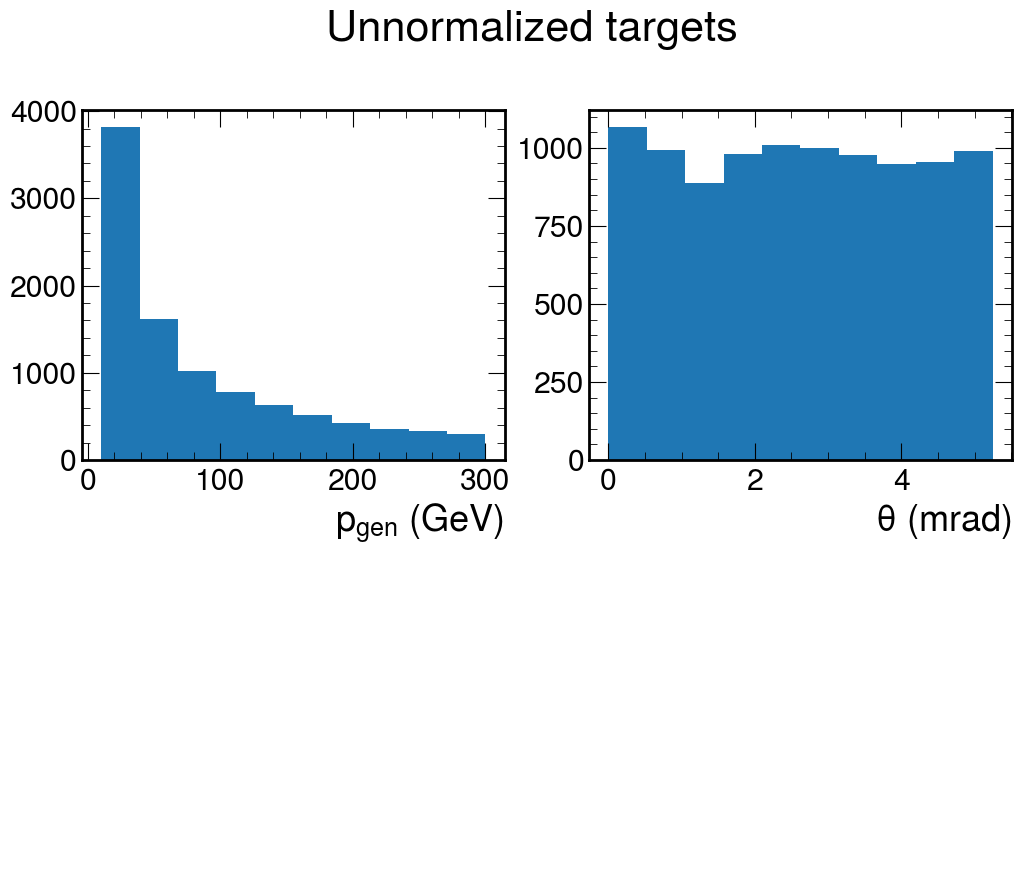

In [6]:
# Plotting the unnormalized target data

# Determine the number of targets and limit the number of subplots accordingly
num_of_targets = len(unnormalized_targets)
num_of_subplots = min(num_of_targets, 4)  # Maximum of 4 subplots

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over the targets and subplots
for i, (key, data) in enumerate(unnormalized_targets.items()):
    if i >= num_of_subplots:
        break
    ax = axs.flatten()[i]
    ax.hist(data)
    ax.set_xlabel(plot_labels[key])

# Hide extra subplots if there are fewer targets
for ax in axs.flatten()[num_of_targets:]:
    ax.axis('off')

plt.suptitle("Unnormalized targets")

Text(0.5, 0.98, 'Normalized targets')

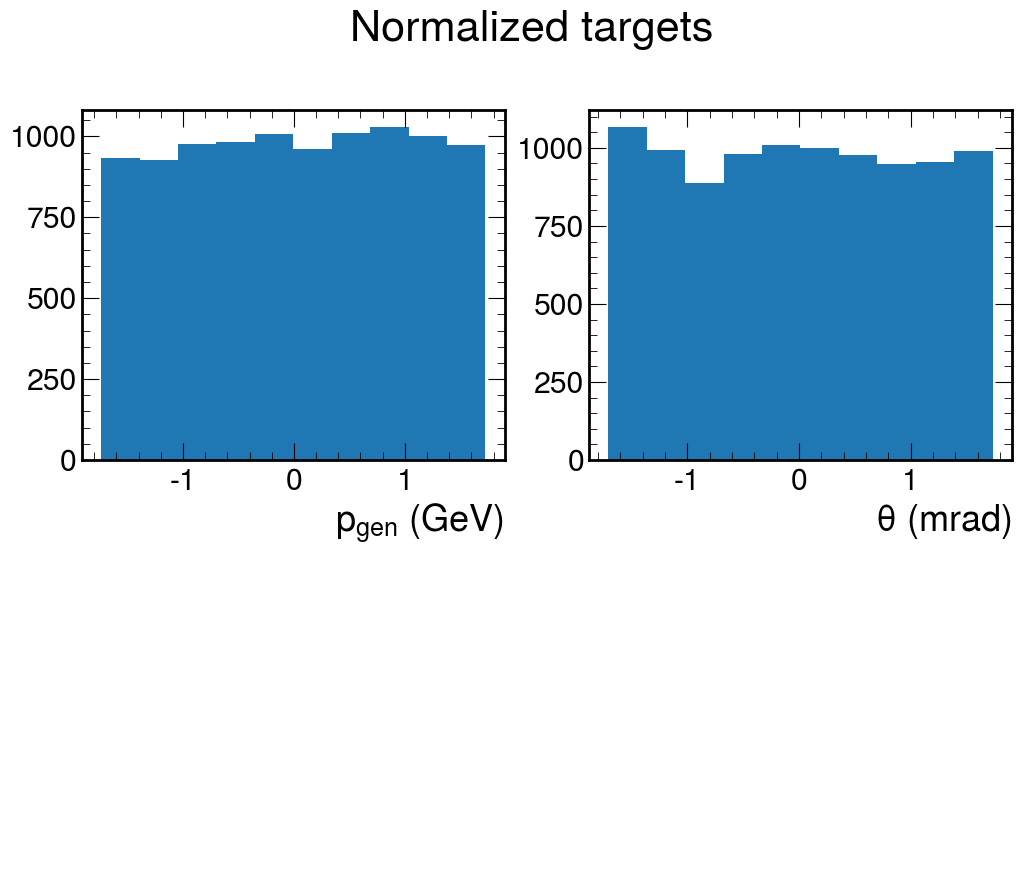

In [7]:
# Plotting the normalized target data

# Determine the number of targets and limit the number of subplots accordingly
num_of_targets = len(unnormalized_targets)
num_of_subplots = min(num_of_targets, 4)  # Maximum of 4 subplots

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over the targets
for i, (key, data) in enumerate(normalized_targets.items()):
    if i >= num_of_subplots:
        break
    ax = axs.flatten()[i]
    ax.hist(data)
    ax.set_xlabel(plot_labels[key])

# Hide extra subplots if there are fewer targets
for ax in axs.flatten()[num_of_targets:]:
    ax.axis('off')

plt.suptitle("Normalized targets")

Text(0.5, 0.98, 'Normalized nodes')

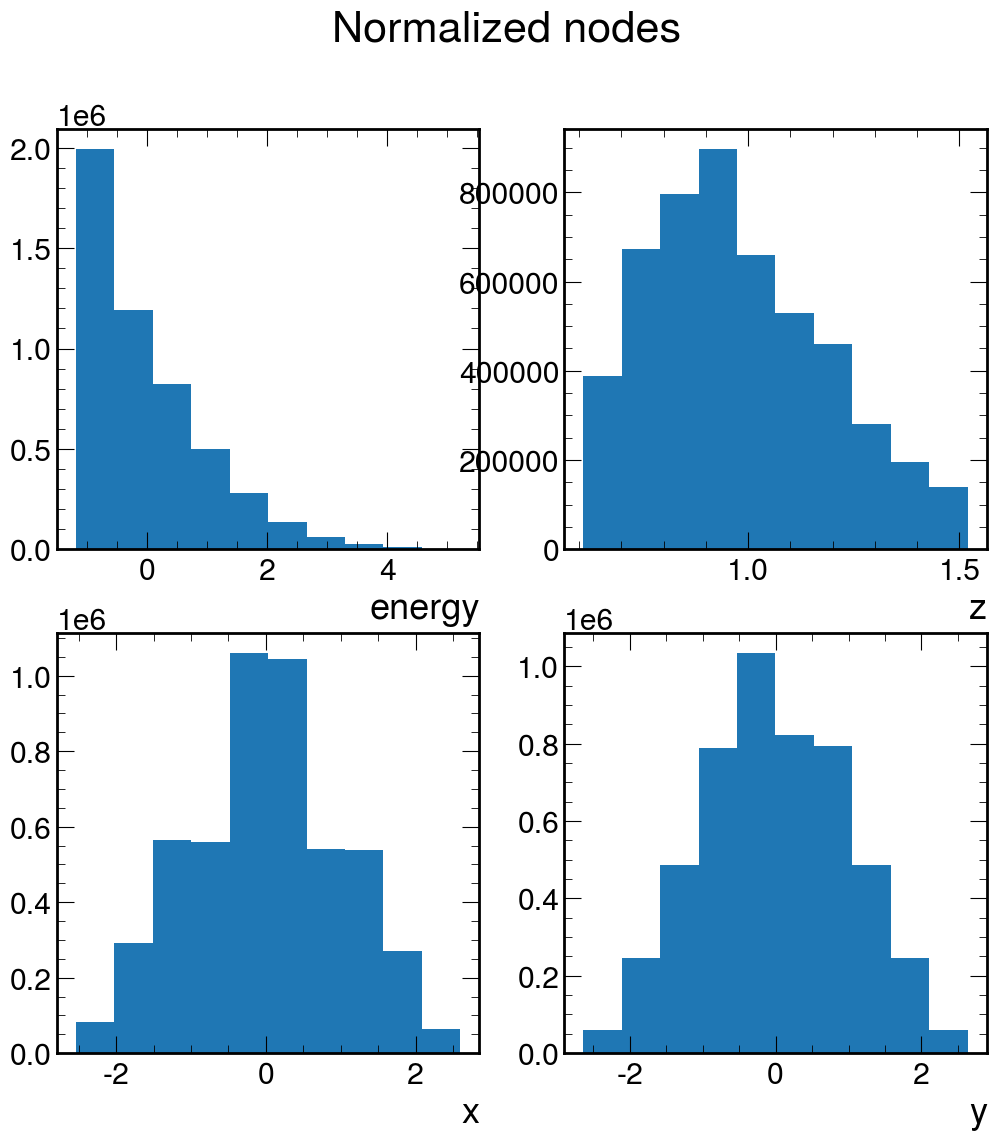

In [8]:
# Plotting the normalized node data
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over the normalized nodes
# Just plot E, x, y, z
for i, (key, data) in enumerate(normalized_nodes.items()):
    if key == "cluster_energy":
        continue
    ax = axs.flatten()[i]
    ax.hist(np.concatenate(data))
    ax.set_xlabel(key)

plt.suptitle("Normalized nodes")

Text(0.5, 0.98, 'Unnormalized nodes')

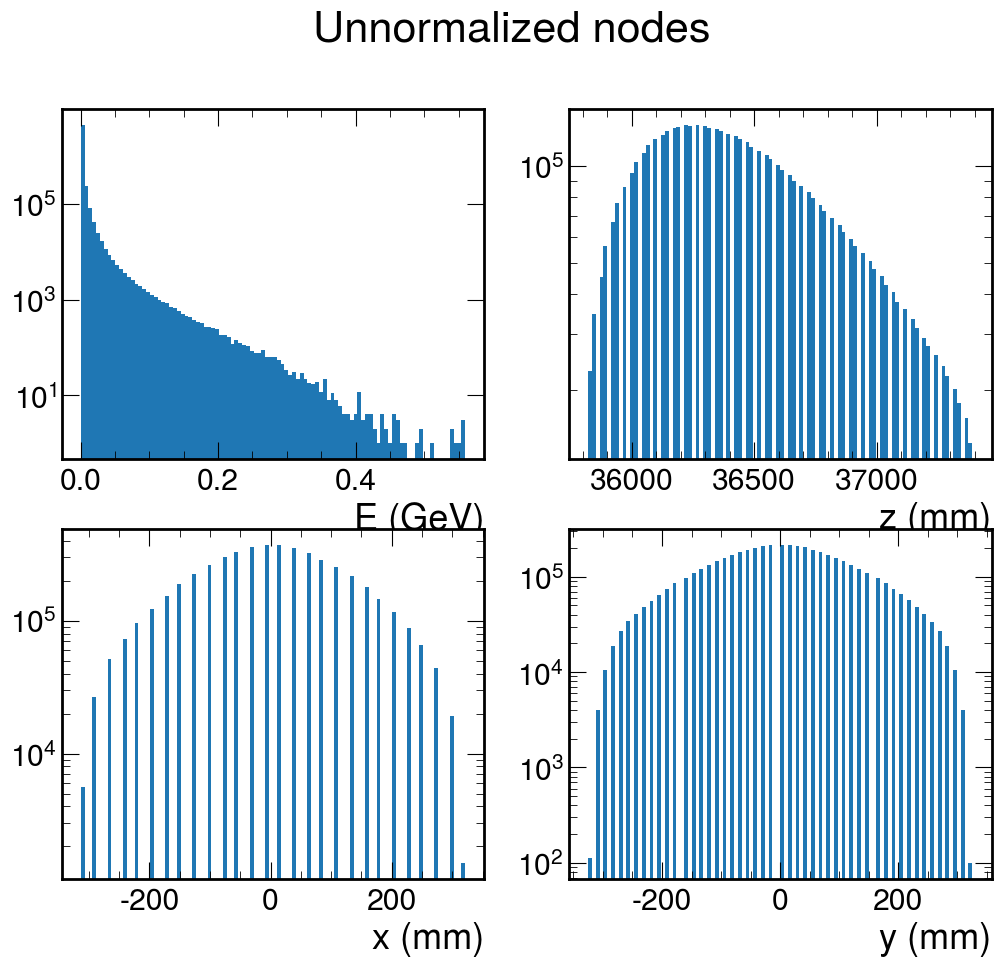

In [9]:
# Plotting the unnormalized node data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over the unnormalized nodes
# Just plot E, x, y, z
for i, (key, data) in enumerate(unnormalized_nodes.items()):
    if key == "cluster_energy":
        continue
    ax = axs.flatten()[i]
    ax.hist(np.concatenate(data), bins=100)
    ax.set_yscale('log')
    ax.set_xlabel(plot_labels[key])

plt.suptitle("Unnormalized nodes")

Text(0, 1, 'Sum of node energies (GeV)')

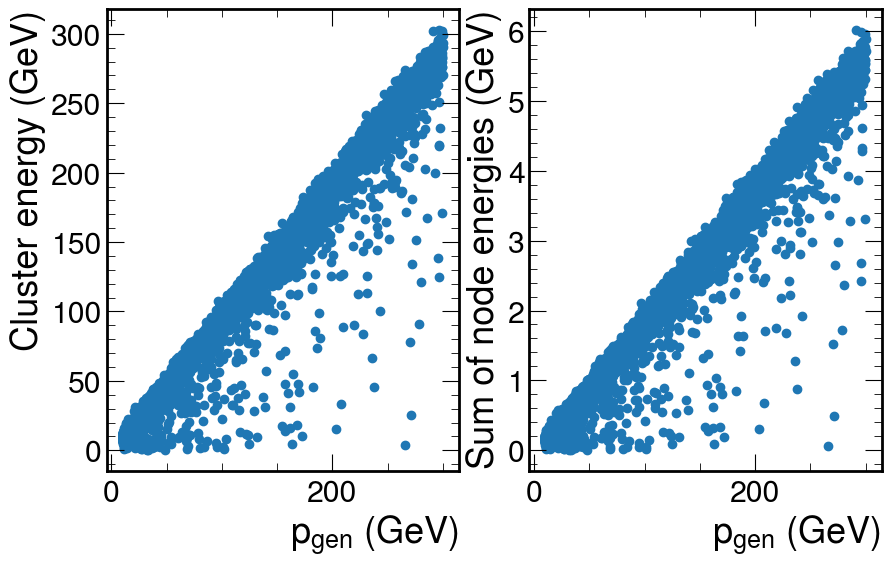

In [10]:
# Plotting the unnormalized node data

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
momentum_variable = "momentum" if "momentum" in unnormalized_targets.keys() else "genP"
axs[0].scatter(unnormalized_targets[momentum_variable], unnormalized_nodes["cluster_energy"])
axs[0].set_xlabel("$p_{gen}$ (GeV)")
axs[0].set_ylabel("Cluster energy (GeV)")

node_event_energy = [np.sum(node_energies) for node_energies in unnormalized_nodes["energy"]]
axs[1].scatter(unnormalized_targets[momentum_variable], node_event_energy)
axs[1].set_xlabel("$p_{gen}$ (GeV)")
axs[1].set_ylabel("Sum of node energies (GeV)")